# Recommender Systems Analysis and Visualization
This notebook performs an exploratory analysis of recommender systems using the Sim4Rec library.
We'll generate synthetic data, compare multiple baseline recommenders, and visualize their performance.


## Cell: Import libraries and set up environment

In [14]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import shutil

from pyspark.sql import SparkSession
from pyspark.sql import functions as sf
from pyspark.sql import DataFrame, Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import DoubleType, ArrayType

# Set up plotting
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)


/tmp/ipykernel_23609/45819036.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Initialize Spark session

In [15]:
spark = (SparkSession.builder
    .appName("RecSysVisualization")
    .master("local[*]")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.shuffle.partitions", "8")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("WARN")

print("Spark session initialized.")

Spark session initialized.


25/05/16 13:44:35 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Import competition modules 

In [16]:
from data_generator import CompetitionDataGenerator
from simulator import CompetitionSimulator
from sample_recommenders import (
    RandomRecommender,
    PopularityRecommender,
    ContentBasedRecommender
)
from config import DEFAULT_CONFIG, EVALUATION_METRICS

print("Competition modules imported.")

Competition modules imported.


## Define custom recommender template
Below is a template class for implementing a custom recommender system. You should extend this class with your own recommendation algorithm.

In [17]:
class MyRecommender:
    """
    Template class for implementing a custom recommender.
    
    This class provides the basic structure required to implement a recommender
    that can be used with the Sim4Rec simulator. Students should extend this class
    with their own recommendation algorithm.
    """
    
    def __init__(self, seed=None):
        """
        Initialize recommender.
        
        Args:
            seed: Random seed for reproducibility
        """
        self.seed = seed
        # Add your initialization logic here
        self.seen = False   
    def fit(self, log, user_features=None, item_features=None):
        """
        Train the recommender model based on interaction history.
        
        Args:
            log: Interaction log with user_idx, item_idx, and relevance columns
            user_features: User features dataframe (optional)
            item_features: Item features dataframe (optional)
        """
        # Implement your training logic here
        print(log, user_features, item_features)
        pass
    
    def predict(self, log:DataFrame, k, users, items, user_features=None, item_features=None, filter_seen_items=True):
        """
        Generate recommendations for users.
        
        Args:
            log: Interaction log with user_idx, item_idx, and relevance columns
            k: Number of items to recommend
            users: User dataframe
            items: Item dataframe
            user_features: User features dataframe (optional)
            item_features: Item features dataframe (optional)
            filter_seen_items: Whether to filter already seen items
        
        Returns:
            DataFrame: Recommendations with user_idx, item_idx, and relevance columns
        """
        if not self.seen: 
            self.seen = True
            log.show(5)
            users.show(5)
            items.show(5)
        # print(log, k, users, items, user_features, item_features)
        # Example of a random recommender implementation:
        # Cross join users and items
        recs = users.crossJoin(items)
        
        # Filter out already seen items if needed
        if filter_seen_items and log is not None:
            seen_items = log.select("user_idx", "item_idx")
            recs = recs.join(
                seen_items,
                on=["user_idx", "item_idx"],
                how="left_anti"
            )
        
        # Add random relevance scores
        recs = recs.withColumn(
            "relevance",
            sf.rand(seed=self.seed)
        )
        
        # Rank items by relevance for each user
        window = Window.partitionBy("user_idx").orderBy(sf.desc("relevance"))
        recs = recs.withColumn("rank", sf.row_number().over(window))
        
        # Filter top-k recommendations
        recs = recs.filter(sf.col("rank") <= k).drop("rank")
        
        return recs

print("MyRecommender template defined.")

MyRecommender template defined.


## Data Exploration Functions
These functions help us understand the generated synthetic data.

In [18]:
def explore_user_data(users_df):
    """
    Explore user data distributions and characteristics.
    
    Args:
        users_df: DataFrame containing user data
    """
    print("=== User Data Exploration ===")
    
    # Get basic statistics
    print(f"Total number of users: {users_df.count()}")
    
    # User segments distribution
    segment_counts = users_df.groupBy("segment").count().toPandas()
    print("\nUser Segments Distribution:")
    for _, row in segment_counts.iterrows():
        print(f"  {row['segment']}: {row['count']} users ({row['count']/users_df.count()*100:.1f}%)")
    
    # Plot user segments
    plt.figure(figsize=(10, 6))
    plt.pie(segment_counts['count'], labels=segment_counts['segment'], autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title('User Segments Distribution')
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('user_segments_distribution.png')
    plt.show()
    print("User segments visualization saved to 'user_segments_distribution.png'")
    
    # Convert to pandas for easier feature analysis
    users_pd = users_df.toPandas()
    
    # Analyze user feature distributions
    feature_cols = [col for col in users_pd.columns if col.startswith('user_attr_')]
    if len(feature_cols) > 0:
        # Take a sample of feature columns if there are many
        sample_features = feature_cols[:min(5, len(feature_cols))]
        
        # Plot histograms for sample features
        plt.figure(figsize=(14, 8))
        for i, feature in enumerate(sample_features):
            plt.subplot(2, 3, i+1)
            for segment in users_pd['segment'].unique():
                segment_data = users_pd[users_pd['segment'] == segment]
                plt.hist(segment_data[feature], alpha=0.5, bins=20, label=segment)
            plt.title(f'Distribution of {feature}')
            plt.xlabel('Value')
            plt.ylabel('Count')
            if i == 0:
                plt.legend()
        plt.tight_layout()
        plt.savefig('user_feature_distributions.png')
        plt.show()
        print("User feature distributions saved to 'user_feature_distributions.png'")
        
        # Feature correlation heatmap
        plt.figure(figsize=(12, 10))
        corr = users_pd[feature_cols].corr()
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(
            corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, annot=False, fmt='.2f'
        )
        plt.title('User Feature Correlations')
        plt.tight_layout()
        plt.savefig('user_feature_correlations.png')
        plt.show()
        print("User feature correlations saved to 'user_feature_correlations.png'")

def explore_item_data(items_df):
    """
    Explore item data distributions and characteristics.
    
    Args:
        items_df: DataFrame containing item data
    """
    print("\n=== Item Data Exploration ===")
    
    # Get basic statistics
    print(f"Total number of items: {items_df.count()}")
    
    # Item categories distribution
    category_counts = items_df.groupBy("category").count().toPandas()
    print("\nItem Categories Distribution:")
    for _, row in category_counts.iterrows():
        print(f"  {row['category']}: {row['count']} items ({row['count']/items_df.count()*100:.1f}%)")
    
    # Plot item categories
    plt.figure(figsize=(10, 6))
    plt.pie(category_counts['count'], labels=category_counts['category'], autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title('Item Categories Distribution')
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('item_categories_distribution.png')
    plt.show()
    print("Item categories visualization saved to 'item_categories_distribution.png'")
    
    # Convert to pandas for easier feature analysis
    items_pd = items_df.toPandas()
    
    # Analyze price distribution
    if 'price' in items_pd.columns:
        plt.figure(figsize=(14, 6))
        
        # Overall price distribution
        plt.subplot(1, 2, 1)
        plt.hist(items_pd['price'], bins=30, alpha=0.7)
        plt.title('Overall Price Distribution')
        plt.xlabel('Price')
        plt.ylabel('Count')
        
        # Price by category
        plt.subplot(1, 2, 2)
        for category in items_pd['category'].unique():
            category_data = items_pd[items_pd['category'] == category]
            plt.hist(category_data['price'], alpha=0.5, bins=20, label=category)
        plt.title('Price Distribution by Category')
        plt.xlabel('Price')
        plt.ylabel('Count')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('item_price_distributions.png')
        plt.show()
        print("Item price distributions saved to 'item_price_distributions.png'")
    
    # Analyze item feature distributions
    feature_cols = [col for col in items_pd.columns if col.startswith('item_attr_')]
    if len(feature_cols) > 0:
        # Take a sample of feature columns if there are many
        sample_features = feature_cols[:min(5, len(feature_cols))]
        
        # Plot histograms for sample features
        plt.figure(figsize=(14, 8))
        for i, feature in enumerate(sample_features):
            plt.subplot(2, 3, i+1)
            for category in items_pd['category'].unique():
                category_data = items_pd[items_pd['category'] == category]
                plt.hist(category_data[feature], alpha=0.5, bins=20, label=category)
            plt.title(f'Distribution of {feature}')
            plt.xlabel('Value')
            plt.ylabel('Count')
            if i == 0:
                plt.legend()
        plt.tight_layout()
        plt.savefig('item_feature_distributions.png')
        plt.show()
        print("Item feature distributions saved to 'item_feature_distributions.png'")

def explore_interactions(history_df, users_df, items_df):
    """
    Explore interaction patterns between users and items.
    
    Args:
        history_df: DataFrame containing interaction history
        users_df: DataFrame containing user data
        items_df: DataFrame containing item data
    """
    print("\n=== Interaction Data Exploration ===")
    
    # Get basic statistics
    total_interactions = history_df.count()
    total_users = users_df.count()
    total_items = items_df.count()
    
    print(f"Total interactions: {total_interactions}")
    print(f"Interaction density: {total_interactions / (total_users * total_items) * 100:.4f}%")
    
    # Users with interactions
    users_with_interactions = history_df.select("user_idx").distinct().count()
    print(f"Users with at least one interaction: {users_with_interactions} ({users_with_interactions/total_users*100:.1f}%)")
    
    # Items with interactions
    items_with_interactions = history_df.select("item_idx").distinct().count()
    print(f"Items with at least one interaction: {items_with_interactions} ({items_with_interactions/total_items*100:.1f}%)")
    
    # Distribution of interactions per user
    interactions_per_user = history_df.groupBy("user_idx").count().toPandas()
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(interactions_per_user['count'], bins=20)
    plt.title('Distribution of Interactions per User')
    plt.xlabel('Number of Interactions')
    plt.ylabel('Number of Users')
    
    # Distribution of interactions per item
    interactions_per_item = history_df.groupBy("item_idx").count().toPandas()
    
    plt.subplot(1, 2, 2)
    plt.hist(interactions_per_item['count'], bins=20)
    plt.title('Distribution of Interactions per Item')
    plt.xlabel('Number of Interactions')
    plt.ylabel('Number of Items')
    
    plt.tight_layout()
    plt.savefig('interaction_distributions.png')
    plt.show()
    print("Interaction distributions saved to 'interaction_distributions.png'")
    
    # Analyze relevance distribution
    if 'relevance' in history_df.columns:
        relevance_dist = history_df.groupBy("relevance").count().toPandas()
        
        plt.figure(figsize=(10, 6))
        plt.bar(relevance_dist['relevance'].astype(str), relevance_dist['count'])
        plt.title('Distribution of Relevance Scores')
        plt.xlabel('Relevance Score')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.savefig('relevance_distribution.png')
        plt.show()
        print("Relevance distribution saved to 'relevance_distribution.png'")
    
    # If we have user segments and item categories, analyze cross-interactions
    if 'segment' in users_df.columns and 'category' in items_df.columns:
        # Join with user segments and item categories
        interaction_analysis = (history_df
            .join(users_df.select('user_idx', 'segment'), on='user_idx')
            .join(items_df.select('item_idx', 'category'), on='item_idx')
        )
        
        # Count interactions by segment and category
        segment_category_counts = interaction_analysis.groupBy('segment', 'category').count().toPandas()
        
        # Create a pivot table
        pivot_table = segment_category_counts.pivot(index='segment', columns='category', values='count').fillna(0)
        
        # Plot heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_table, annot=True, fmt='g', cmap='viridis')
        plt.title('Interactions Between User Segments and Item Categories')
        plt.tight_layout()
        plt.savefig('segment_category_interactions.png')
        plt.show()
        print("Segment-category interactions saved to 'segment_category_interactions.png'")

print("Data exploration functions defined.")

Data exploration functions defined.


## Performance Visualization Functions
These functions create visualizations for comparing recommender performance.

In [19]:
def visualize_recommender_performance(results_df, recommender_names):
    """
    Visualize the performance of recommenders in terms of revenue and key metrics.
    
    Args:
        results_df: DataFrame with evaluation results
        recommender_names: List of recommender names
    """
    plt.figure(figsize=(16, 16))
    
    # Plot total revenue comparison
    plt.subplot(3, 2, 1)
    x = np.arange(len(recommender_names))
    width = 0.35
    plt.bar(x - width/2, results_df['train_total_revenue'], width, label='Training')
    plt.bar(x + width/2, results_df['test_total_revenue'], width, label='Testing')
    plt.xlabel('Recommender')
    plt.ylabel('Total Revenue')
    plt.title('Total Revenue Comparison')
    plt.xticks(x, results_df['name'])
    plt.legend()
    
    # Plot average revenue per iteration
    plt.subplot(3, 2, 2)
    plt.bar(x - width/2, results_df['train_avg_revenue'], width, label='Training')
    plt.bar(x + width/2, results_df['test_avg_revenue'], width, label='Testing')
    plt.xlabel('Recommender')
    plt.ylabel('Avg Revenue per Iteration')
    plt.title('Average Revenue Comparison')
    plt.xticks(x, results_df['name'])
    plt.legend()
    
    # Plot discounted revenue comparison (if available)
    plt.subplot(3, 2, 3)
    if 'train_discounted_revenue' in results_df.columns and 'test_discounted_revenue' in results_df.columns:
        plt.bar(x - width/2, results_df['train_discounted_revenue'], width, label='Training')
        plt.bar(x + width/2, results_df['test_discounted_revenue'], width, label='Testing')
        plt.xlabel('Recommender')
        plt.ylabel('Avg Discounted Revenue')
        plt.title('Discounted Revenue Comparison')
        plt.xticks(x, results_df['name'])
        plt.legend()
    
    # Plot revenue trajectories
    plt.subplot(3, 2, 4)
    markers = ['o', 's', 'D', '^']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i, name in enumerate(results_df['name']):
        # Combined train and test trajectories
        train_revenue = results_df.iloc[i]['train_revenue']
        test_revenue = results_df.iloc[i]['test_revenue']
        
        # Ensure they are lists
        if isinstance(train_revenue, (float, np.floating, int, np.integer)):
            train_revenue = [train_revenue]
        if isinstance(test_revenue, (float, np.floating, int, np.integer)):
            test_revenue = [test_revenue]
        
        iterations = list(range(len(train_revenue))) + list(range(len(test_revenue)))
        revenues = train_revenue + test_revenue
        
        plt.plot(iterations, revenues, marker=markers[i % len(markers)], 
                 color=colors[i % len(colors)], label=name)
        
        # Add a vertical line to separate train and test
        if i == 0:  # Only add the line once
            plt.axvline(x=len(train_revenue)-0.5, color='k', linestyle='--', alpha=0.3, label='Train/Test Split')
    
    plt.xlabel('Iteration')
    plt.ylabel('Revenue')
    plt.title('Revenue Trajectory (Training → Testing)')
    plt.legend()
    
    # Plot ranking metrics comparison - Training
    plt.subplot(3, 2, 5)
    
    # Select metrics to include
    ranking_metrics = ['precision_at_k', 'ndcg_at_k', 'mrr', 'hit_rate']
    ranking_metrics = [m for m in ranking_metrics if f'train_{m}' in results_df.columns]
    
    # Create bar groups
    bar_positions = np.arange(len(ranking_metrics))
    bar_width = 0.8 / len(results_df)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # Extended palette
    
    for i, (_, row) in enumerate(results_df.iterrows()):
        model_name = row['name']
        offsets = (i - len(results_df)/2 + 0.5) * bar_width
        metric_values = [row[f'train_{m}'] for m in ranking_metrics]
        plt.bar(bar_positions + offsets, metric_values, bar_width, label=model_name, 
                color=colors[i % len(colors)], alpha=0.7)
    
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title('Ranking Metrics Comparison (Training Phase)')
    plt.xticks(bar_positions, [m.replace('_', ' ').title() for m in ranking_metrics])
    plt.legend()
    
    # Plot ranking metrics comparison - Testing
    plt.subplot(3, 2, 6)
    
    ranking_metrics = ['precision_at_k', 'ndcg_at_k', 'mrr', 'hit_rate']
    ranking_metrics = [m for m in ranking_metrics if f'test_{m}' in results_df.columns]
    
    # Get best-performing model (by test total revenue) to highlight
    best_model_idx = results_df['test_total_revenue'].idxmax()
    best_model_name = results_df.iloc[best_model_idx]['name']
    
    bar_positions = np.arange(len(ranking_metrics))
    bar_width = 0.8 / len(results_df)
    
    for i, (_, row) in enumerate(results_df.iterrows()):
        model_name = row['name']
        offsets = (i - len(results_df)/2 + 0.5) * bar_width
        metric_values = [row[f'test_{m}'] for m in ranking_metrics]
        plt.bar(bar_positions + offsets, metric_values, bar_width, label=model_name, 
                color=colors[i % len(colors)],
                alpha=0.7 if model_name != best_model_name else 1.0)
    
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title('Ranking Metrics Comparison (Test Phase)')
    plt.xticks(bar_positions, [m.replace('_', ' ').title() for m in ranking_metrics])
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('recommender_performance_comparison.png')
    plt.show()
    print("\nPerformance visualizations saved to 'recommender_performance_comparison.png'")

def visualize_detailed_metrics(results_df, recommender_names):
    """
    Create detailed visualizations for each metric and recommender.
    
    Args:
        results_df: DataFrame with evaluation results
        recommender_names: List of recommender names
    """
    # Create a figure for metric trajectories
    plt.figure(figsize=(16, 16))
    
    # Get all available metrics
    all_metrics = []
    if len(results_df) > 0 and 'train_metrics' in results_df.columns:
        first_train_metrics = results_df.iloc[0]['train_metrics'][0]
        all_metrics = list(first_train_metrics.keys())
    
    # Select key metrics to visualize
    key_metrics = ['revenue', 'discounted_revenue', 'precision_at_k', 'ndcg_at_k', 'mrr', 'hit_rate']
    key_metrics = [m for m in key_metrics if m in all_metrics]
    
    # Plot metric trajectories for each key metric
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    markers = ['o', 's', 'D', '^']
    
    for i, metric in enumerate(key_metrics):
        if i < 6:  # Limit to 6 metrics to avoid overcrowding
            plt.subplot(3, 2, i+1)
            
            for j, name in enumerate(results_df['name']):
                row = results_df[results_df['name'] == name].iloc[0]
                
                # Get metric values for training phase
                train_values = []
                for train_metric in row['train_metrics']:
                    if metric in train_metric:
                        train_values.append(train_metric[metric])
                
                # Get metric values for testing phase
                test_values = []
                for test_metric in row['test_metrics']:
                    if metric in test_metric:
                        test_values.append(test_metric[metric])
                
                # Plot training phase
                plt.plot(
                    range(len(train_values)),
                    train_values,
                    marker=markers[j % len(markers)],
                    color=colors[j % len(colors)],
                    linestyle='-',
                    label=f"{name} (train)"
                )
                
                # Plot testing phase
                plt.plot(
                    range(len(train_values), len(train_values) + len(test_values)),
                    test_values,
                    marker=markers[j % len(markers)],
                    color=colors[j % len(colors)],
                    linestyle='--',
                    label=f"{name} (test)"
                )
                
                # Add a vertical line to separate train and test
                if j == 0:  # Only add the line once
                    plt.axvline(x=len(train_values) - 0.5, color='k', linestyle='--', alpha=0.3, label='Train/Test Split')
            
            # Get metric info from EVALUATION_METRICS if available
            if metric in EVALUATION_METRICS:
                metric_info = EVALUATION_METRICS[metric]
                metric_name = metric_info['name']
                plt.title(f"{metric_name} Trajectory")
            else:
                plt.title(f"{metric.replace('_', ' ').title()} Trajectory")
            
            plt.xlabel('Iteration')
            plt.ylabel('Value')
            
            # Add legend to the last plot or the final one in layout
            if i == len(key_metrics) - 1 or i == 5:
                plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.savefig('recommender_metrics_trajectories.png')
    plt.show()
    print("Detailed metrics visualizations saved to 'recommender_metrics_trajectories.png'")
    
    # Create a correlation heatmap of metrics
    plt.figure(figsize=(14, 12))
    
    # Extract metrics columns
    metric_cols = [col for col in results_df.columns if col.startswith('train_') or col.startswith('test_')]
    metric_cols = [col for col in metric_cols if not col.endswith('_metrics') and not col.endswith('_revenue')]
    
    if len(metric_cols) > 1:
        correlation_df = results_df[metric_cols].corr()
        # Plot heatmap
        sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Between Metrics')
        plt.tight_layout()
        plt.savefig('metrics_correlation_heatmap.png')
        plt.show()
        print("Metrics correlation heatmap saved to 'metrics_correlation_heatmap.png'")

def calculate_discounted_cumulative_gain(recommendations, k=5, discount_factor=0.85):
    """
    Calculate the Discounted Cumulative Gain for recommendations.
    
    Args:
        recommendations: DataFrame with recommendations (must have relevance column)
        k: Number of items to consider
        discount_factor: Factor to discount gains by position
    
    Returns:
        float: Average DCG across all users
    """
    # Group by user and calculate per-user DCG
    user_dcg = []
    grouped_recs = (recommendations
        .groupBy("user_idx")
        .agg(sf.collect_list(sf.struct("relevance", "rank")).alias("recommendations"))
    ).collect()
    
    for row in grouped_recs:
        user_id = row['user_idx']
        user_rec_list = sorted(row['recommendations'], key=lambda x: x[1])
        
        dcg = 0
        for i, rec in enumerate(user_rec_list[:k]):
            rel = rec['relevance']
            # Apply discount based on position
            dcg += rel * (discount_factor ** i)
        user_dcg.append(dcg)
    
    return np.mean(user_dcg) if user_dcg else 0.0

print("Performance visualization functions defined.")

Performance visualization functions defined.


## Generate Data and Perform Exploratory Analysis

Running train-test simulation with 5 training iterations and 5 testing iterations
Generated 1000 users


Generated 200 items
Generated 200 initial interactions

=== Starting Exploratory Data Analysis ===
=== User Data Exploration ===
Total number of users: 1000

User Segments Distribution:
  budget: 300 users (30.0%)
  mainstream: 500 users (50.0%)
  premium: 200 users (20.0%)


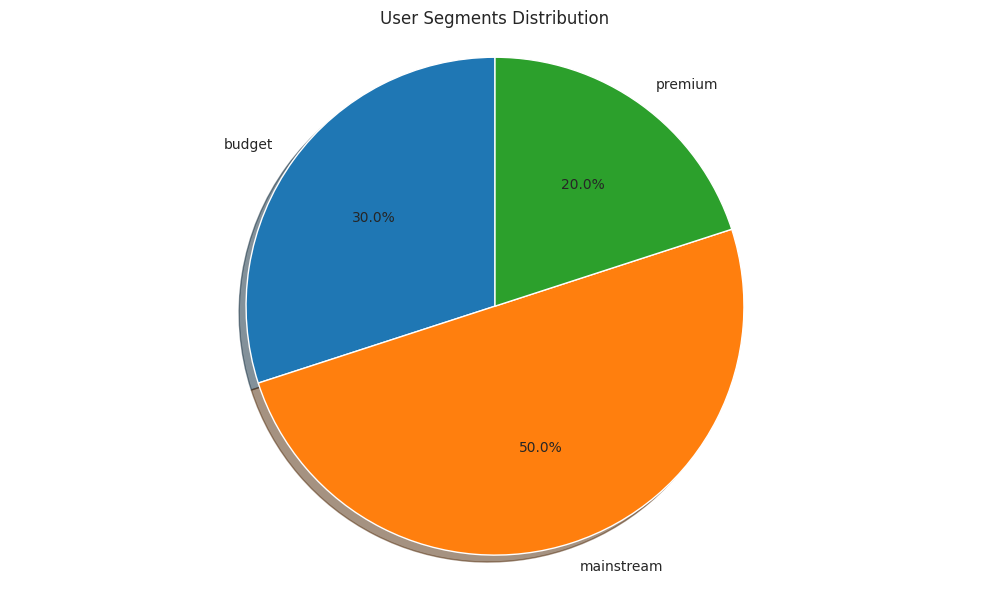

User segments visualization saved to 'user_segments_distribution.png'


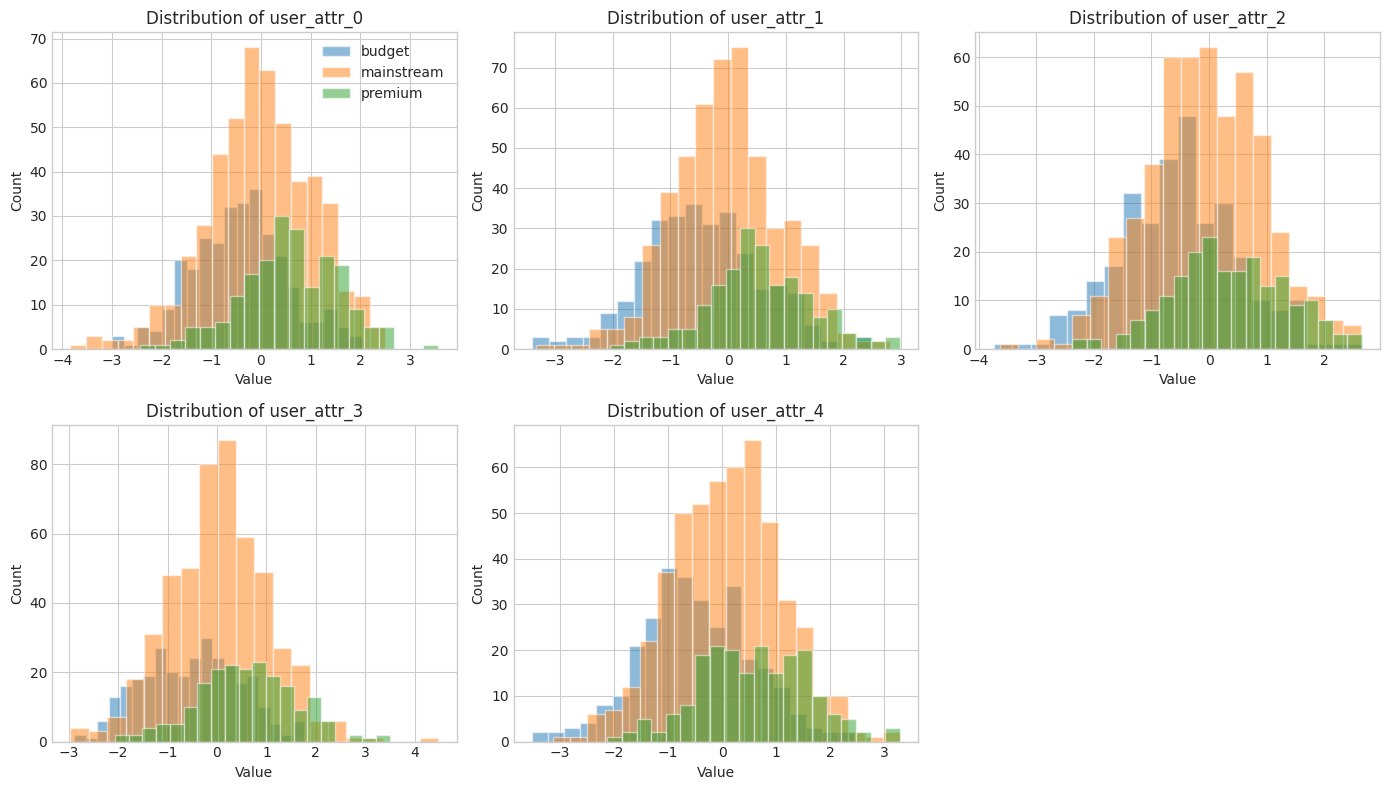

User feature distributions saved to 'user_feature_distributions.png'


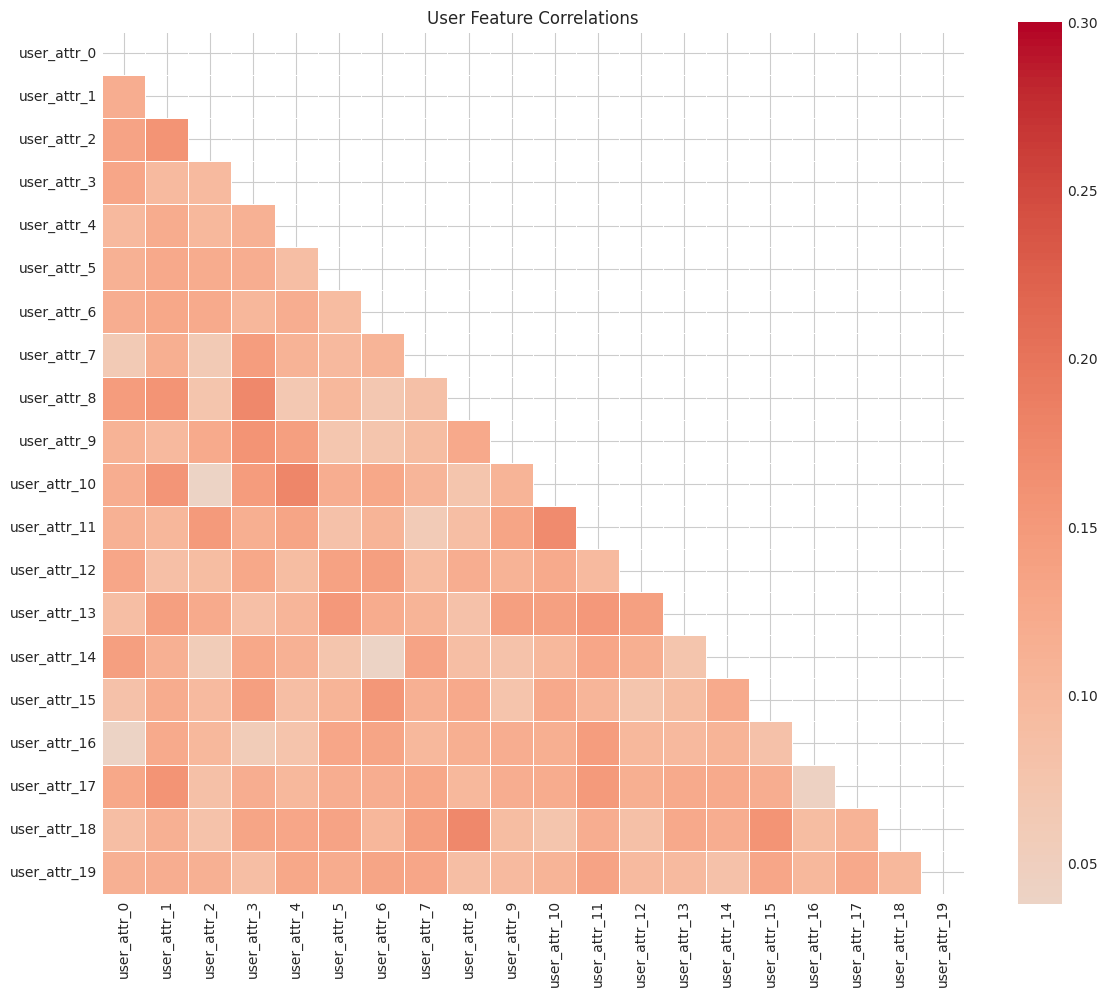

User feature correlations saved to 'user_feature_correlations.png'

=== Item Data Exploration ===
Total number of items: 200

Item Categories Distribution:
  electronics: 40 items (20.0%)
  books: 60 items (30.0%)
  clothing: 60 items (30.0%)
  home: 40 items (20.0%)


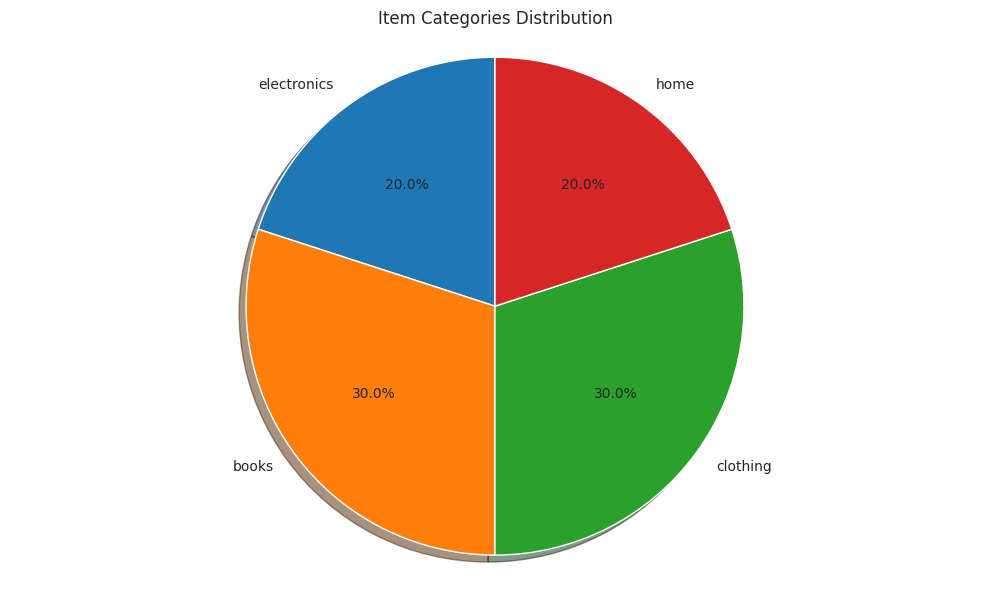

Item categories visualization saved to 'item_categories_distribution.png'


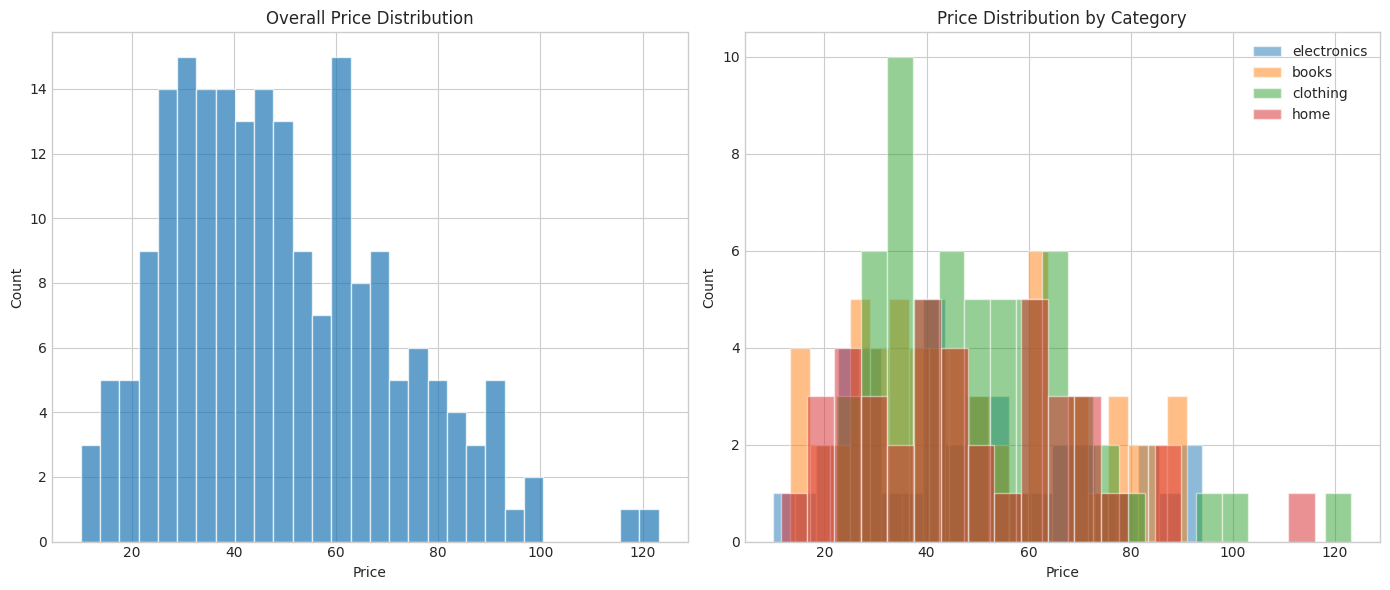

Item price distributions saved to 'item_price_distributions.png'


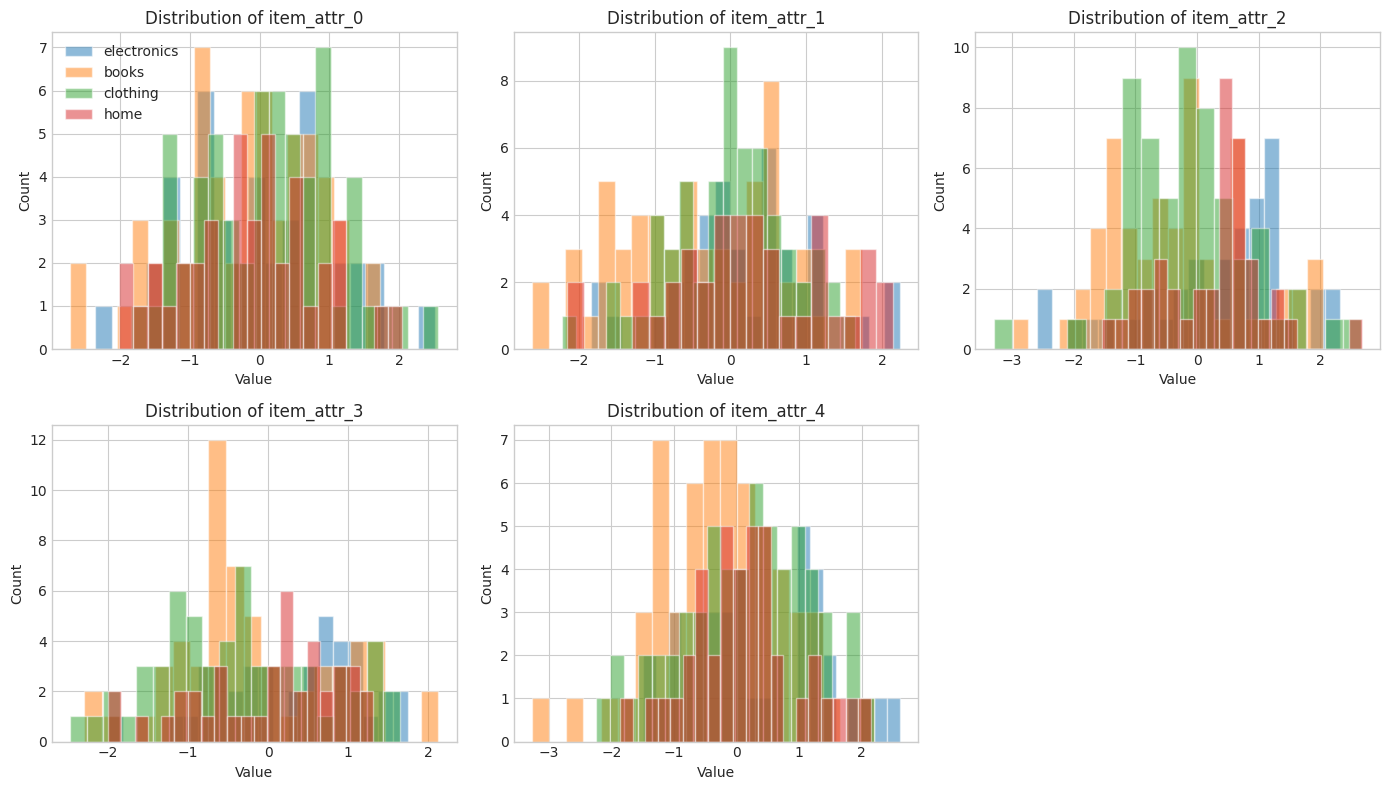

Item feature distributions saved to 'item_feature_distributions.png'

=== Interaction Data Exploration ===
Total interactions: 200
Interaction density: 0.1000%
Users with at least one interaction: 181 (18.1%)
Items with at least one interaction: 132 (66.0%)


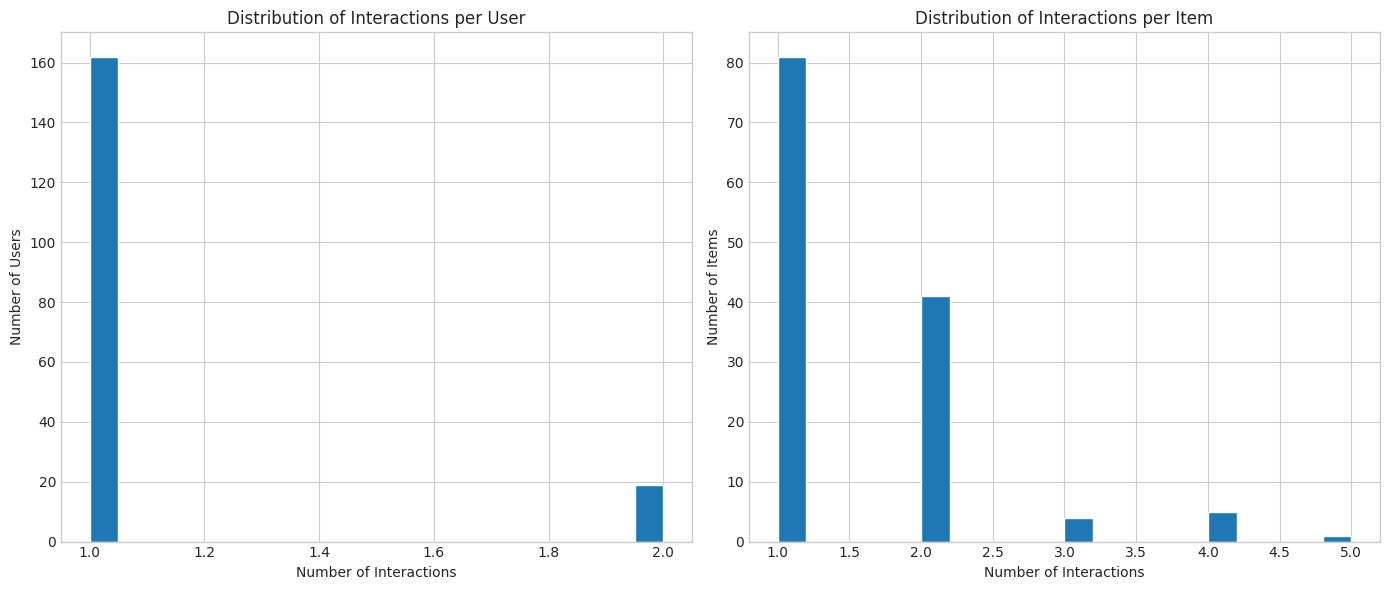

Interaction distributions saved to 'interaction_distributions.png'


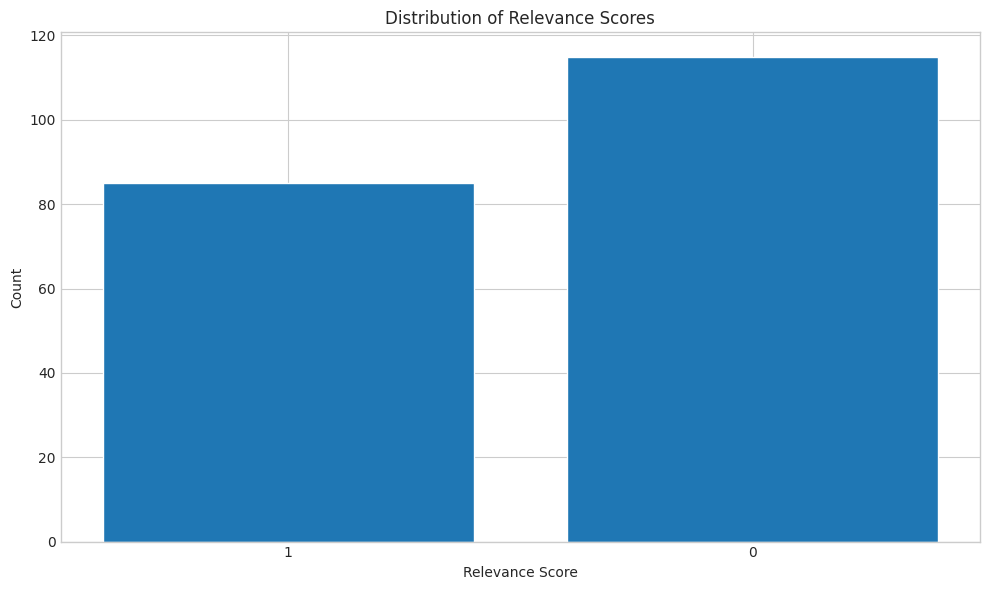

Relevance distribution saved to 'relevance_distribution.png'


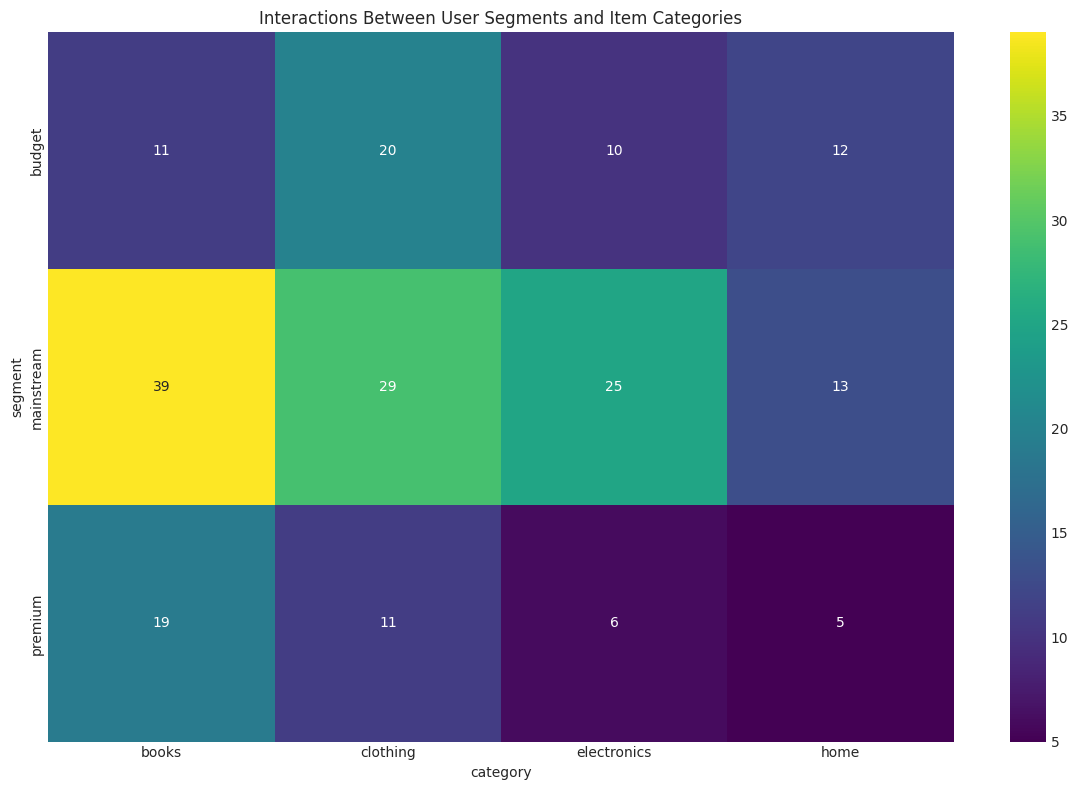

Segment-category interactions saved to 'segment_category_interactions.png'
Exploratory analysis complete.


In [20]:
# We'll create a smaller dataset for demonstration.
config = DEFAULT_CONFIG.copy()
config['data_generation']['n_users'] = 1000  # Reduced from 10,000
config['data_generation']['n_items'] = 200   # Reduced from 1,000
config['data_generation']['seed'] = 42       # Fixed seed for reproducibility

# Get train-test split parameters
train_iterations = config['simulation']['train_iterations']
test_iterations = config['simulation']['test_iterations']

print(f"Running train-test simulation with {train_iterations} training iterations and {test_iterations} testing iterations")

# Initialize data generator
data_generator = CompetitionDataGenerator(
    spark_session=spark,
    **config['data_generation']
)

# Generate user data
users_df = data_generator.generate_users()
print(f"Generated {users_df.count()} users")

# Generate item data
items_df = data_generator.generate_items()
print(f"Generated {items_df.count()} items")

# Generate initial interaction history
history_df = data_generator.generate_initial_history(
    config['data_generation']['initial_history_density']
)
print(f"Generated {history_df.count()} initial interactions")

print("\n=== Starting Exploratory Data Analysis ===")
explore_user_data(users_df)
explore_item_data(items_df)
explore_interactions(history_df, users_df, items_df)

print("Exploratory analysis complete.")

## Set up Generators and Recommenders

In [21]:
# Prepare data generators for the simulator
user_generator, item_generator = data_generator.setup_data_generators()

# Initialize the recommenders we want to compare
recommenders = [
    # RandomRecommender(seed=42),
    # PopularityRecommender(alpha=1.0, seed=42),
    # ContentBasedRecommender(similarity_threshold=0.0, seed=42),
    MyRecommender(seed=42)  # Custom template class
]
recommender_names = [
    # "Random", "Popularity", "ContentBased", 
    "MyRecommender"
    ]

# Fit each recommender on the initial history
for recommender in recommenders:
    recommender.fit(log=data_generator.history_df)

print("Recommenders set up and initial fit complete.")

25/05/16 13:44:44 WARN CacheManager: Asked to cache already cached data.
25/05/16 13:44:44 WARN CacheManager: Asked to cache already cached data.
25/05/16 13:44:44 WARN CacheManager: Asked to cache already cached data.


DataFrame[user_idx: bigint, item_idx: bigint, relevance: bigint] None None
Recommenders set up and initial fit complete.


25/05/16 13:44:45 WARN CacheManager: Asked to cache already cached data.
25/05/16 13:44:45 WARN CacheManager: Asked to cache already cached data.


## Train-Test Simulation and Evaluation

In [22]:
import pandas as pd

results = []

for name, recommender in zip(recommender_names, recommenders):
    print(f"\nEvaluating {name}:")
    
    # Clean up any existing simulator data directory for this recommender
    simulator_data_dir = f"simulator_train_test_data_{name}"
    if os.path.exists(simulator_data_dir):
        shutil.rmtree(simulator_data_dir)
        print(f"Removed existing simulator data directory: {simulator_data_dir}")
    
    # Initialize simulator
    simulator = CompetitionSimulator(
        user_generator=user_generator,
        item_generator=item_generator,
        data_dir=simulator_data_dir,
        log_df=data_generator.history_df,  # PySpark DataFrames don't have copy method
        conversion_noise_mean=config['simulation']['conversion_noise_mean'],
        conversion_noise_std=config['simulation']['conversion_noise_std'],
        spark_session=spark,
        seed=config['data_generation']['seed']
    )
    
    # Run simulation with train-test split
    train_metrics, test_metrics, train_revenue, test_revenue = simulator.train_test_split(
        recommender=recommender,
        train_iterations=train_iterations,
        test_iterations=test_iterations,
        user_frac=config['simulation']['user_fraction'],
        k=config['simulation']['k'],
        filter_seen_items=config['simulation']['filter_seen_items'],
        retrain=config['simulation']['retrain']
    )
    
    # Calculate average metrics
    train_avg_metrics = {}
    for metric_name in train_metrics[0].keys():
        values = [m[metric_name] for m in train_metrics]
        train_avg_metrics[f"train_{metric_name}"] = np.mean(values)
    
    test_avg_metrics = {}
    for metric_name in test_metrics[0].keys():
        values = [m[metric_name] for m in test_metrics]
        test_avg_metrics[f"test_{metric_name}"] = np.mean(values)
    
    # Store results
    results.append({
        "name": name,
        "train_total_revenue": sum(train_revenue),
        "test_total_revenue": sum(test_revenue),
        "train_avg_revenue": np.mean(train_revenue),
        "test_avg_revenue": np.mean(test_revenue),
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
        "train_revenue": train_revenue,
        "test_revenue": test_revenue,
        **train_avg_metrics,
        **test_avg_metrics
    })
    
    # Print summary for this recommender
    print(f"  Training Phase - Total Revenue: {sum(train_revenue):.2f}")
    print(f"  Testing Phase - Total Revenue: {sum(test_revenue):.2f}")
    performance_change = ((sum(test_revenue) / len(test_revenue)) / (sum(train_revenue) / len(train_revenue)) - 1) * 100
    print(f"  Performance Change: {performance_change:.2f}%")

print("\n=== Simulation and evaluation complete for all recommenders. ===")

# Convert to DataFrame for easy comparison
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("test_total_revenue", ascending=False).reset_index(drop=True)

# Print summary table
print("\nRecommender Evaluation Results (sorted by test revenue):")
summary_cols = [
    "name", "train_total_revenue", "test_total_revenue", 
    "train_avg_revenue", "test_avg_revenue",
    "train_precision_at_k", "test_precision_at_k",
    "train_ndcg_at_k", "test_ndcg_at_k",
    "train_mrr", "test_mrr",
    "train_discounted_revenue", "test_discounted_revenue"
]
summary_cols = [col for col in summary_cols if col in results_df.columns]

if len(summary_cols) > 0:
    print(results_df[summary_cols].to_string(index=False))
else:
    print("No summary columns to display.")


Evaluating MyRecommender:
Removed existing simulator data directory: simulator_train_test_data_MyRecommender
Starting Training Phase:


25/05/16 13:44:45 WARN CacheManager: Asked to cache already cached data.


+--------+--------+---------+------+
|user_idx|item_idx|relevance|__iter|
+--------+--------+---------+------+
|     566|      72|        0| start|
|      78|      10|        0| start|
|     512|      46|        1| start|
|     679|      22|        0| start|
|      22|      80|        1| start|
+--------+--------+---------+------+
only showing top 5 rows

+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------+-------+
|         user_attr_0|         user_attr_1|         user_attr_2|         user_attr_3|        user_attr_4|         user_attr_5|         user_attr_6|        user_attr_7|         user_attr_8|        user_attr_9|  

25/05/16 13:44:48 WARN CacheManager: Asked to cache already cached data.


Training Iteration 1: Revenue = 2215.13
DataFrame[user_idx: bigint, item_idx: bigint, relevance: int, __iter: string] None None


25/05/16 13:44:49 WARN CacheManager: Asked to cache already cached data.


Training Iteration 2: Revenue = 2672.33
DataFrame[user_idx: bigint, item_idx: bigint, relevance: int, __iter: string] None None


25/05/16 13:44:51 WARN CacheManager: Asked to cache already cached data.


Training Iteration 3: Revenue = 3109.84
DataFrame[user_idx: bigint, item_idx: bigint, relevance: int, __iter: string] None None


25/05/16 13:44:52 WARN CacheManager: Asked to cache already cached data.


Training Iteration 4: Revenue = 2226.96
DataFrame[user_idx: bigint, item_idx: bigint, relevance: int, __iter: string] None None

Starting Testing Phase:


25/05/16 13:44:53 WARN CacheManager: Asked to cache already cached data.


Testing Iteration 0: Revenue = 2534.22


25/05/16 13:44:55 WARN CacheManager: Asked to cache already cached data.


Testing Iteration 1: Revenue = 1788.47


25/05/16 13:44:56 WARN CacheManager: Asked to cache already cached data.


Testing Iteration 2: Revenue = 2282.28


25/05/16 13:44:57 WARN CacheManager: Asked to cache already cached data.


Testing Iteration 3: Revenue = 1815.53


25/05/16 13:44:59 WARN CacheManager: Asked to cache already cached data.


Testing Iteration 4: Revenue = 3194.47
  Training Phase - Total Revenue: 13414.26
  Testing Phase - Total Revenue: 11614.97
  Performance Change: -13.41%

=== Simulation and evaluation complete for all recommenders. ===

Recommender Evaluation Results (sorted by test revenue):
         name  train_total_revenue  test_total_revenue  train_avg_revenue  test_avg_revenue  train_precision_at_k  test_precision_at_k  train_ndcg_at_k  test_ndcg_at_k  train_mrr  test_mrr  train_discounted_revenue  test_discounted_revenue
MyRecommender         13414.261383        11614.965759        2682.852277       2322.993152              0.110745             0.095031         0.603185        0.639331    0.21071  0.199452               1553.643168              1403.086613


## Results Visualization


=== Visualizing Recommender Performance ===


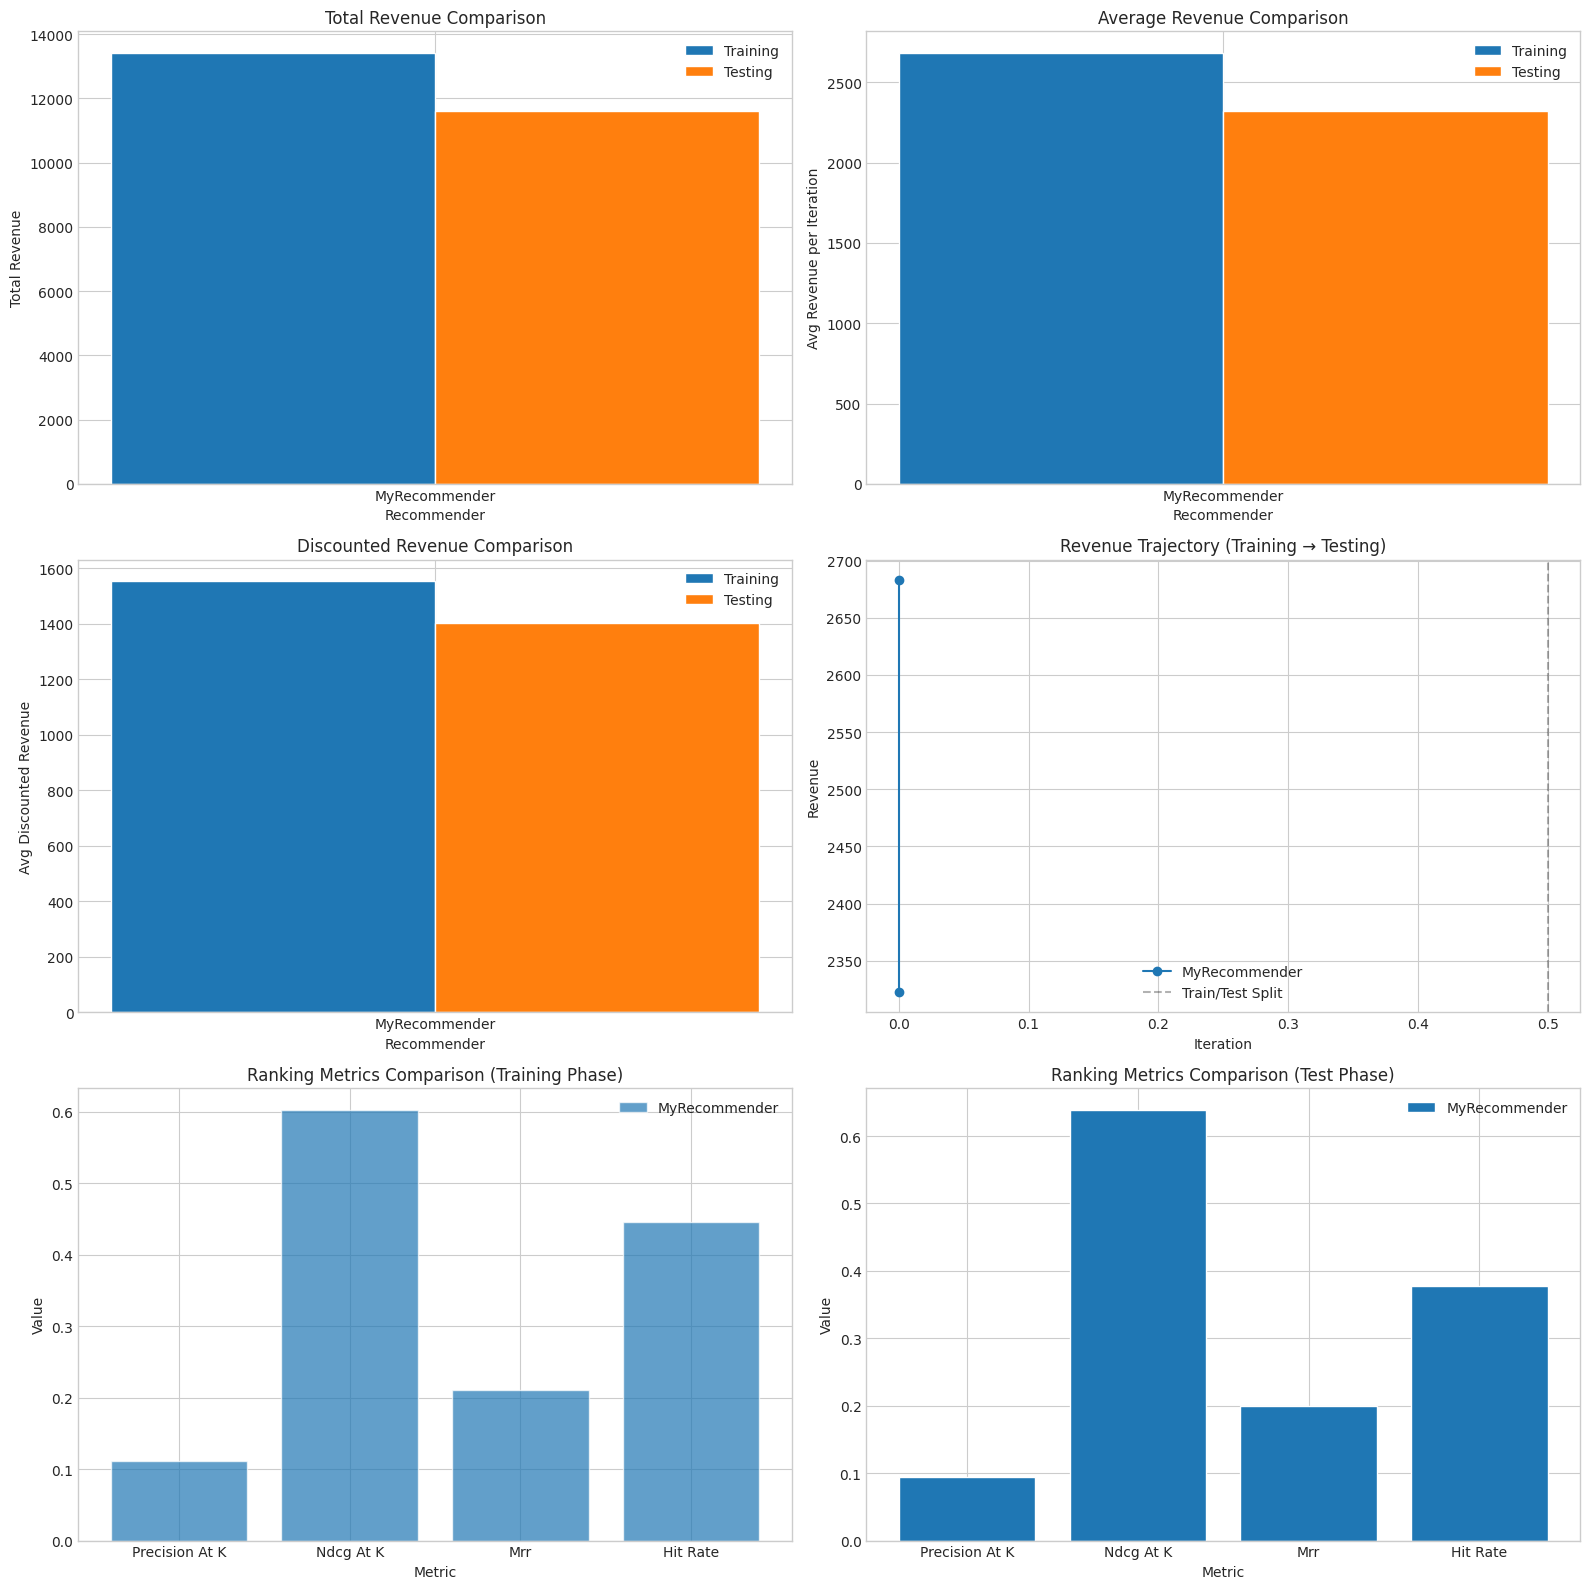


Performance visualizations saved to 'recommender_performance_comparison.png'


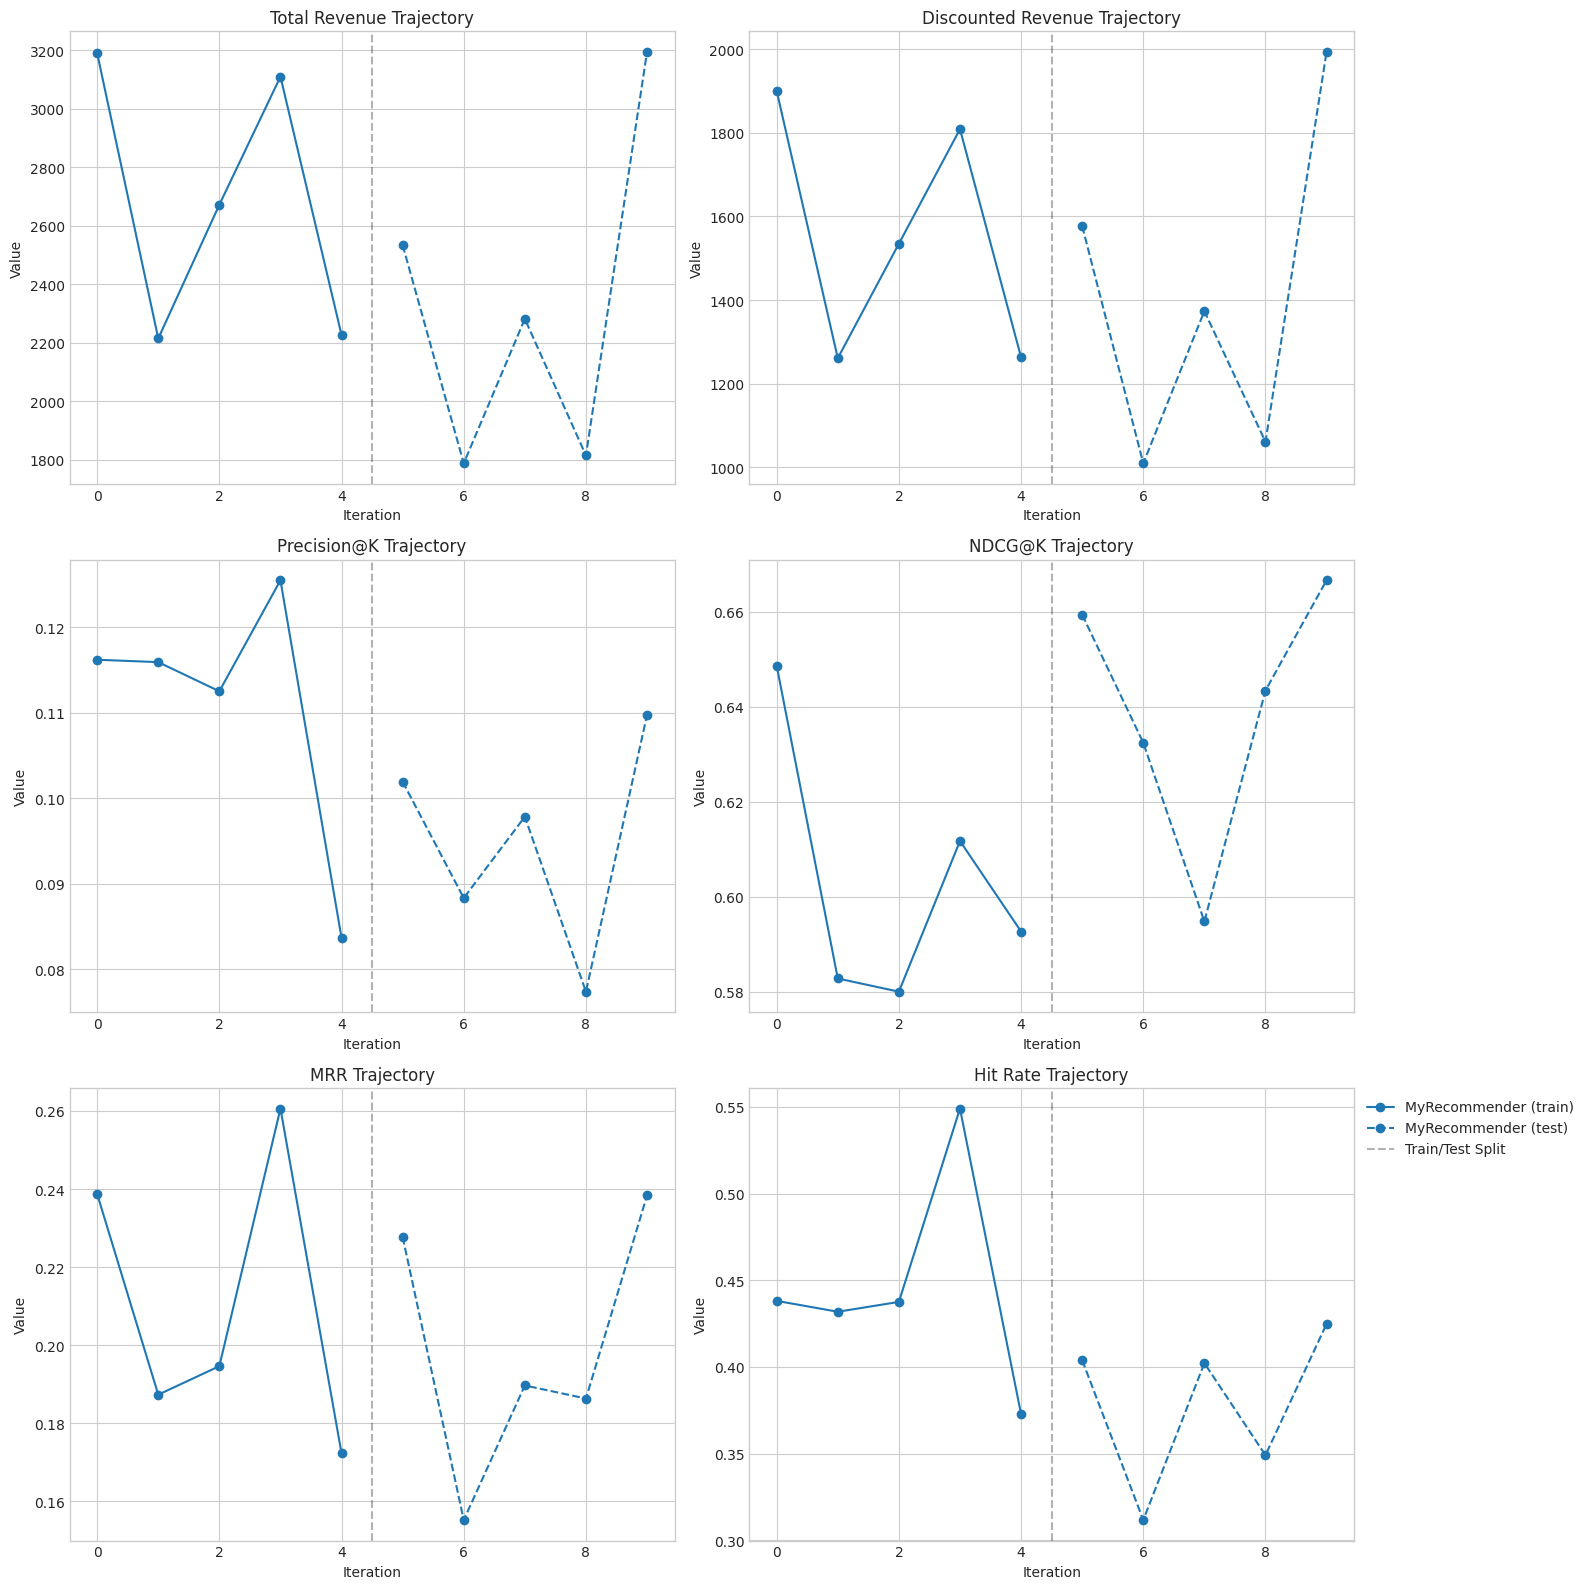

Detailed metrics visualizations saved to 'recommender_metrics_trajectories.png'


/home/morgan/miniconda3/envs/venv39/lib/python3.9/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/morgan/miniconda3/envs/venv39/lib/python3.9/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


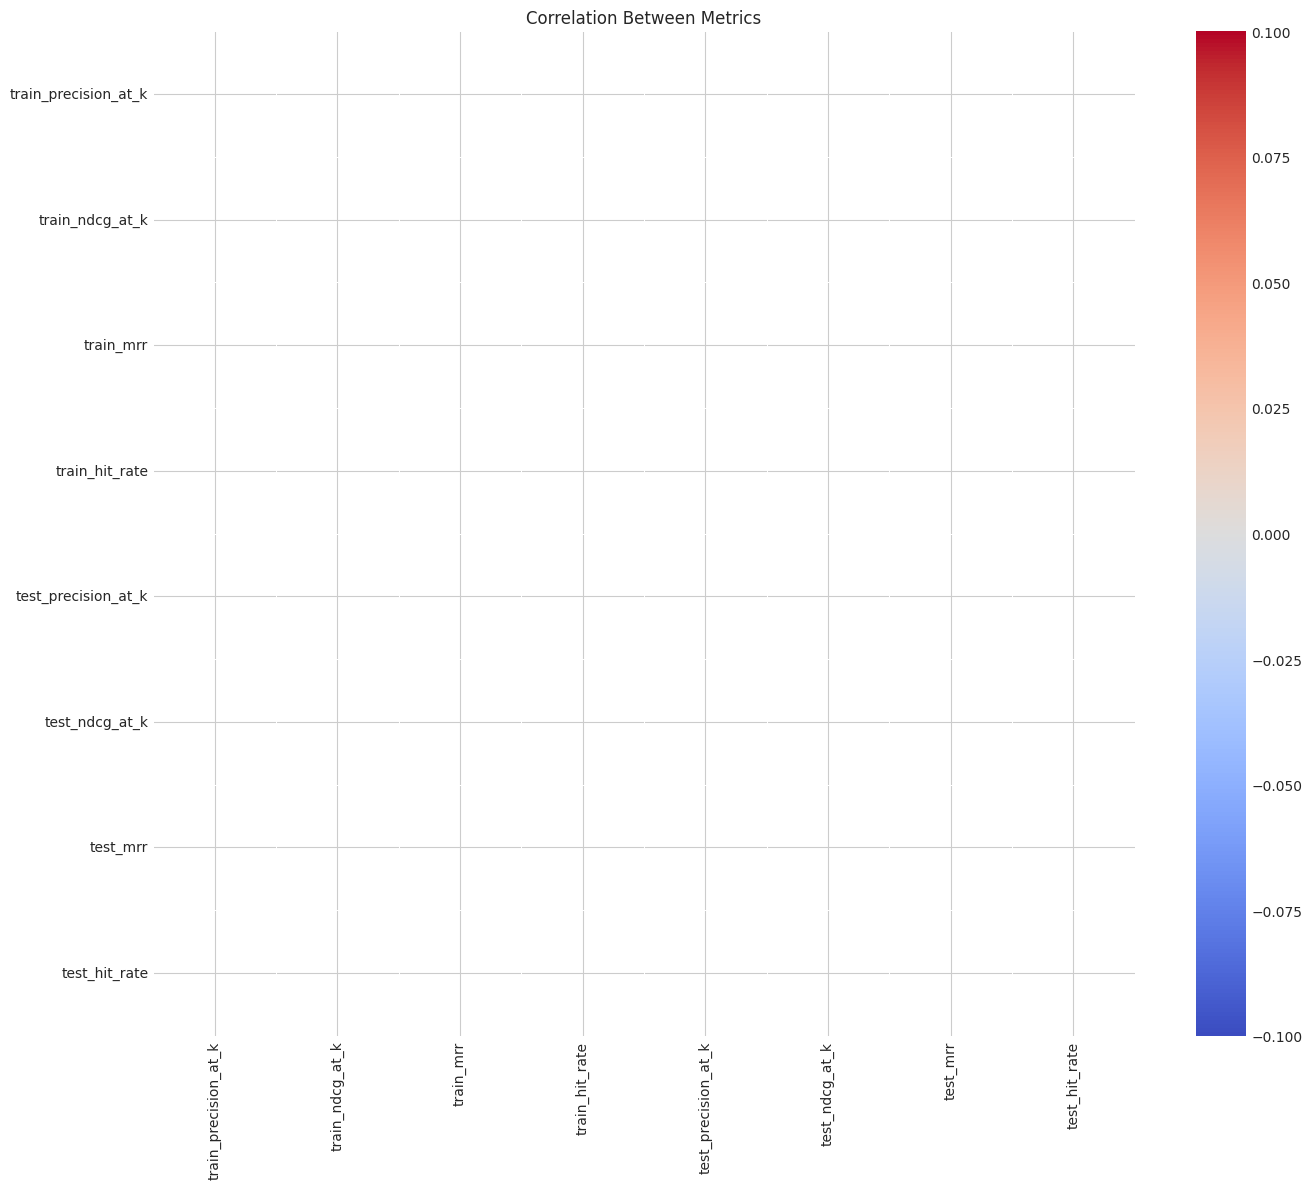

Metrics correlation heatmap saved to 'metrics_correlation_heatmap.png'

Visualization complete.


In [23]:
print("\n=== Visualizing Recommender Performance ===")
visualize_recommender_performance(results_df, recommender_names)
visualize_detailed_metrics(results_df, recommender_names)

print("\nVisualization complete.")